In [2]:
pip install control

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import control
from control.matlab import ctrb, place, obsv

import numpy as np
from numpy.linalg import eig, matrix_rank
from scipy import integrate
import matplotlib.pyplot as plt

In [4]:
# Example 0
A = [[0, 1], 
     [-1, 0]]

B = [[0], 
     [1]]

C = [[1, 0]]

print(A)

[[0, 1], [-1, 0]]


In [5]:
# Exosystem matrix
S = [[0]]

# Reference signal and matrix
ref = 10
R = [[1]]

In [6]:
# Compute eigenvalues, eigenvectors
w,v = eig(A)
print('eigenvalues:', w)

eigenvalues: [0.+1.j 0.-1.j]


In [7]:
# Controllability matrix
W_c = ctrb(A, B)
matrix_rank(W_c)

np.int64(2)

In [8]:
# Eigenvalue assignment
P = place(A,B,[-1,-2])
F1 = -P
print(F1)

w,v = eig(A+B*F1)
print('eigenvalues:', w)

[[-1. -3.]]
eigenvalues: [-1. -2.]


In [9]:
# Design of F2 and F
F2 = [[2]]

F = np.concatenate((F1, F2), axis=1)
print(F)

[[-1. -3.  2.]]


In [10]:
# Augmented matrices
X1 = np.concatenate((A, np.zeros((2,1))), axis=1)
X2 = np.concatenate((np.zeros((1,2)), S), axis=1)
A_tilde = np.concatenate((X1,X2), axis=0)

B_tilde = np.concatenate((B, np.zeros((1,1))), axis=0)


C_tilde = np.concatenate((np.zeros((1,2))-C, R), axis=1)

In [11]:
# Observability matrix
W_o_tilde=obsv(A_tilde, C_tilde)
matrix_rank(W_o_tilde)

np.int64(3)

In [12]:
# Eigenvalue assignment
P = place(np.transpose(A_tilde),np.transpose(C_tilde),[-2,-3,-4])
L = -np.transpose(P)
print(L)

print(eig(A_tilde+L*C_tilde))

[[-15.]
 [ 25.]
 [-24.]]
EigResult(eigenvalues=array([-4., -3., -2.]), eigenvectors=array([[ 0.53916387, -0.57346234,  0.62076591],
       [-0.53916387,  0.49153915, -0.39503285],
       [ 0.64699664, -0.65538554,  0.67719918]]))


In [13]:
# Closed-loop system matrix
X1 = np.concatenate((A_tilde, np.dot(B_tilde,F)), axis=1)
X2 = np.concatenate((np.zeros((1,3))-np.dot(L,C_tilde), A_tilde+np.dot(B_tilde,F)+np.dot(L,C_tilde)), axis=1)
A_cl = np.concatenate((X1,X2), axis=0)

print(A_cl)

w_cl,v_cl = eig(A_cl)
print('eigenvalues:', w_cl)

[[  0.   1.   0.   0.   0.   0.]
 [ -1.   0.   0.  -1.  -3.   2.]
 [  0.   0.   0.   0.   0.   0.]
 [-15.   0.  15.  15.   1. -15.]
 [ 25.   0. -25. -27.  -3.  27.]
 [-24.   0.  24.  24.   0. -24.]]
eigenvalues: [-4.         -3.         -2.00000017 -1.99999983 -1.          0.        ]


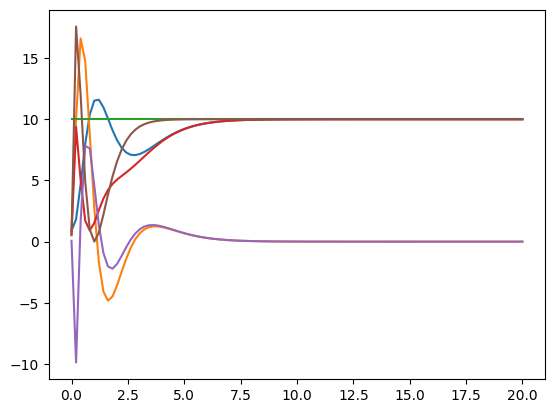

In [14]:
# Plot
def f(t, x):
    return np.dot(A_cl,x)

t0, t1 = 0, 20                # start and end
t = np.linspace(t0, t1, 100)  # the points of evaluation of solution             
x0 = [np.random.uniform(-1, 1), np.random.uniform(-1, 1), ref, np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)] # initial value
#print(x0)
x = np.zeros((len(t), len(x0)))   # array for solution
x[0,:] = x0
r = integrate.ode(f).set_integrator("dopri5")  # choice of method
r.set_initial_value(x0, t0)   # initial values

for i in range(1, t.size):
   x[i, :] = r.integrate(t[i]) # get one more value, add it to the array
   if not r.successful():
       raise RuntimeError("Could not integrate")
plt.plot(t, x)
plt.show()

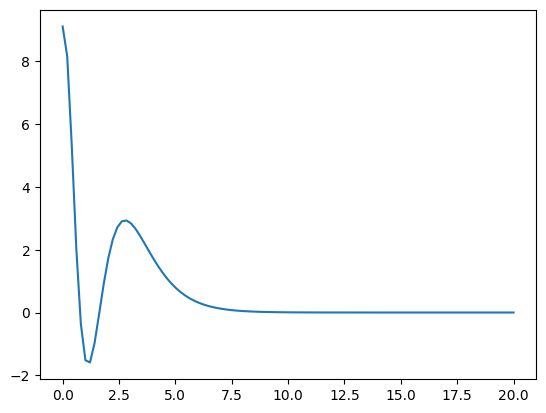

In [15]:
# Tracking error
e = np.zeros((len(t), 1))

E = np.concatenate((np.zeros((1,2))-C,R), axis=1)

for i in range(0, t.size):
   e[i, :] = np.dot(E,x[i, 0:3])
plt.plot(t, e)
plt.show()